In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Imports
import warnings
warnings.filterwarnings('ignore')

import sys

if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1
    !pip install Levenshtein

import os
import gc
import time
import random
import pickle
import Levenshtein
import difflib
import multiprocessing
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
from tqdm.auto import tqdm
from requests import get
from collections import Counter, defaultdict
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import haversine_distances

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [ ]:
def get_distribution(y_vals):
    y_distr = Counter(y_vals)
    y_vals_sum = sum(y_distr.values())
    return [f'{y_distr[i] / y_vals_sum:.2%}' for i in range(np.max(y_vals) + 1)]

In [ ]:
## Parameters
class CFG:
    AUTHOR = "kuruton"
    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]
    ROOT_DIR = '/content/drive/MyDrive/Kaggle/Foursquare'
    DATASET_DIR = os.path.join(ROOT_DIR, 'Dataset')
    INPUT_DIR = os.path.join(ROOT_DIR, 'Input')
    OUTPUT_DIR = os.path.join(ROOT_DIR, 'Output')
    is_debug = False
    SEED = 2022
    num_neighbors = 20
    num_split = 5
    feat_columns = ['name', 'address', 'city', 
                'state', 'zip', 'categories']
    vec_columns = ['name', 'categories', 'address', 
                  'state']

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed_everything(CFG.SEED)

In [ ]:
if not os.path.exists(os.path.join(CFG.OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(CFG.OUTPUT_DIR, CFG.expID))

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
def recall_knn(df, Neighbors = 10):
    print('Start knn')
    train_df = []
    knn = NearestNeighbors(n_neighbors = Neighbors)
    knn.fit(df[['latitude','longitude']], df.index)
    dists, nears = knn.kneighbors(df[['latitude','longitude']])
    
    for k in range(Neighbors):            
        cur_df = df[['id']]
        cur_df['match_id'] = df['id'].values[nears[:, k]]
        cur_df['kdist'] = dists[:, k]
        cur_df['kneighbors'] = k
        train_df.append(cur_df)
    
    train_df = pd.concat(train_df)
    train_df = train_df.reset_index()
    
    return train_df

In [ ]:
def add_features(df, set_num):    
    for col in tqdm(CFG.feat_columns):       
        if col in CFG.vec_columns:
            tv_fit = tfidf_d[col]
            indexs = [id2index_d[i] for i in df['id']]
            match_indexs = [id2index_d[i] for i in df['match_id']]                    
            df[f'{col}_sim'] = tv_fit[indexs].multiply(tv_fit[match_indexs]).sum(axis = 1).A.ravel()
        
        col_values = data.loc[df['id']][col].values.astype(str)
        matcol_values = data.loc[df['match_id']][col].values.astype(str)
        vc = data.loc[data['set'] == set_num, col].value_counts() / sum(data['set'] == set_num)
        geshs = []
        levens = []
        jaros = []
        lcss = []
        vc1 = []
        vc2 = []

        for s, match_s in zip(col_values, matcol_values):
            if s != 'nan':
                vc1.append(vc[s])
            else:
                vc1.append(np.nan)

            if match_s != 'nan':
                vc2.append(vc[match_s])
            else:
                vc2.append(np.nan)

            if s != 'nan' and match_s != 'nan':                    
                geshs.append(difflib.SequenceMatcher(None, s, match_s).ratio())
                levens.append(Levenshtein.distance(s, match_s))
                jaros.append(Levenshtein.jaro_winkler(s, match_s))
                lcss.append(LCS(str(s), str(match_s)))
            else:
                geshs.append(np.nan)
                levens.append(np.nan)
                jaros.append(np.nan)
                lcss.append(np.nan)
        
        df[f'{col}_gesh'] = geshs
        df[f'{col}_leven'] = levens
        df[f'{col}_jaro'] = jaros
        df[f'{col}_lcs'] = lcss
        df[f'{col}_CE_1'] = vc1
        df[f'{col}_CE_2'] = vc2
        
        if col not in ['phone', 'zip']:
            df[f'{col}_len'] = list(map(len, col_values))
            df[f'match_{col}_len'] = list(map(len, matcol_values)) 
            df[f'{col}_len_diff'] = np.abs(df[f'{col}_len'] - df[f'match_{col}_len'])
            df[f'{col}_nleven'] = df[f'{col}_leven'] / \
                                    df[[f'{col}_len', f'match_{col}_len']].max(axis = 1)
            
            df[f'{col}_nlcsk'] = df[f'{col}_lcs'] / df[f'match_{col}_len']
            df[f'{col}_nlcs'] = df[f'{col}_lcs'] / df[f'{col}_len']
            
            df = df.drop(f'{col}_len', axis = 1)
            df = df.drop(f'match_{col}_len', axis = 1)
            gc.collect()
    return df

In [ ]:
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

def get_score(input_df: pd.DataFrame):
    scores = []
    for id_str, matches in zip(input_df['id'].to_numpy(), input_df['matches'].to_numpy()):
        targets = poi2ids[id2poi[id_str]]
        preds = set(matches.split())
        score = len((targets & preds)) / len((targets | preds))
        scores.append(score)
    scores = np.array(scores)
    return scores.mean()

def analysis(df):
    print('Num of data: %s' % len(df))
    print('Num of unique id: %s' % df['id'].nunique())
    print('Num of unique poi: %s' % df['point_of_interest'].nunique())
    
    poi_grouped = df.groupby('point_of_interest')['id'].count().reset_index()
    print('Mean num of unique poi: %s' % poi_grouped['id'].mean())

In [ ]:
## Data load
if "google.colab" in sys.modules:
    data_root = CFG.INPUT_DIR
else:
    data_root = '../input/foursquare-location-matching'
data = pd.read_csv(os.path.join(data_root, 'train.csv'))

if CFG.is_debug:
    data = data.sample(n = 100000, random_state = CFG.SEED)
    data = data.reset_index(drop = True)

In [ ]:
data['POI_count'] = data['point_of_interest'].map(dict(data.groupby('point_of_interest')['id'].apply(len)))
data.loc[data['POI_count'] > 5, 'POI_count'] = 5
data['POI_count'] -= 1
data.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest,POI_count
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e,1
1,E_000002eae2a589,Carioca Manero,-22.907225,-43.178244,NaN,NaN,NaN,NaN,BR,NaN,NaN,Brazilian Restaurants,P_d82910d8382a83,1
2,E_000007f24ebc95,ร้านตัดผมการาเกด,13.780813,100.484900,NaN,NaN,NaN,NaN,TH,NaN,NaN,Salons / Barbershops,P_b1066599e78477,0
3,E_000008a8ba4f48,Turkcell,37.844510,27.844202,Adnan Menderes Bulvarı,NaN,NaN,NaN,TR,NaN,NaN,Mobile Phone Shops,P_b2ed86905a4cd3,0
4,E_00001d92066153,Restaurante Casa Cofiño,43.338196,-4.326821,NaN,Caviedes,Cantabria,NaN,ES,NaN,NaN,Spanish Restaurants,P_809a884d4407fb,1


In [ ]:
distrs = [get_distribution(data['POI_count'])]
index = ['training set']

for set_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(data, data['POI_count'], data["point_of_interest"], k=2, seed=CFG.SEED)):
    data.loc[val_ind, "set"] = set_ind

    dev_y, val_y = data.loc[dev_ind, 'POI_count'], data.loc[val_ind, 'POI_count']
    dev_groups, val_groups = data.loc[dev_ind, "point_of_interest"], data.loc[val_ind, "point_of_interest"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - set {set_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - set {set_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(data['POI_count']) + 1)])

'Distribution per class:'

,Label 0,Label 1,Label 2,Label 3,Label 4
training set,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 0,37.32%,48.77%,6.38%,2.08%,5.44%
validation set - set 0,37.32%,48.77%,6.38%,2.09%,5.44%
development set - set 1,37.32%,48.77%,6.38%,2.09%,5.44%
validation set - set 1,37.32%,48.77%,6.38%,2.08%,5.44%


In [ ]:
# Data split
print('Num of train data: %s' % len(data))
print(data['set'].value_counts())

train_data = data.loc[data['set'] == 0]
test_data = data.loc[data['set'] == 1]

print('Train data: ')
analysis(train_data)
print('Test data: ')
analysis(test_data)

train_poi = train_data['point_of_interest'].unique().tolist()
test_poi = test_data['point_of_interest'].unique().tolist()

print(set(train_poi) & set(test_poi))

train_ids = train_data['id'].unique().tolist()
test_ids = test_data['id'].unique().tolist()
      
print(set(train_ids) & set(test_ids))
      
tv_ids_d = {}
tv_ids_d['train_ids'] = train_ids
tv_ids_d['test_ids'] = test_ids

np.save('tv_ids_d.npy', tv_ids_d)

del train_data, test_data
gc.collect()

data = data.set_index('id')
data = data.reset_index()

Num of train data: 1138812
0.0    569408
1.0    569404
Name: set, dtype: int64
Train data: 
Num of data: 569408
Num of unique id: 569408
Num of unique poi: 369986
Mean num of unique poi: 1.538998772926543
Test data: 
Num of data: 569404
Num of unique id: 569404
Num of unique poi: 369986
Mean num of unique poi: 1.538987961706659
set()
set()


In [ ]:
## Train data generated by knn
id2index_d = dict(zip(data['id'].values, data.index))

tfidf_d = {}
for col in CFG.vec_columns:
    tfidf = TfidfVectorizer()
    tfidf.fit(data[col].fillna('nan'))
    tv_fit = tfidf.transform(data[col].fillna('nan'))
    tfidf_d[col] = tv_fit

train_data = recall_knn(data.loc[data['set'] == 0], CFG.num_neighbors)
test_data = recall_knn(data.loc[data['set'] == 1], CFG.num_neighbors)

data = data.set_index('id')
ids = train_data['id'].tolist()
match_ids = train_data['match_id'].tolist()

poi = data.loc[ids]['point_of_interest'].values
match_poi = data.loc[match_ids]['point_of_interest'].values

train_data['label'] = np.array(poi == match_poi, dtype = np.int8)

test_ids = test_data['id'].tolist()
test_match_ids = test_data['match_id'].tolist()

test_poi = data.loc[test_ids]['point_of_interest'].values
test_match_poi = data.loc[test_match_ids]['point_of_interest'].values

test_data['label'] = np.array(test_poi == test_match_poi, dtype = np.int8)
del poi, match_poi, ids, match_ids, test_poi, test_match_poi, test_ids, test_match_ids
gc.collect()

print('Num of unique id: %s' % train_data['id'].nunique())
print('Num of train data: %s' % len(train_data))
print('Pos rate: %s' % train_data['label'].mean())
print(train_data.sample(5))

Start knn
Start knn
Num of unique id: 569408
Num of train data: 11388160
Pos rate: 0.08787117497471057
           index                id          match_id     kdist  kneighbors  \
3758063   683961  E_99a140a34f285e  E_c6d67cce880b89  0.004885           6   
4129113   286764  E_405f9c2c763e2a  E_3ff9414bca6b59  0.001146           7   
4251869   532418  E_77a7261e5e52fa  E_e9f5c8e7e65b69  0.003156           7   
10838572   39651  E_08e1f8e863777c  E_897b6d8bf8b758  0.009152          19   
348480    697719  E_9cb61b103c9671  E_9cb61b103c9671  0.000000           0   

          label  
3758063       0  
4129113       0  
4251869       0  
10838572      0  
348480        1  


In [ ]:
## Eval
data = data.reset_index()

id2poi = get_id2poi(data)
poi2ids = get_poi2ids(data)

eval_df = pd.DataFrame()
eval_df['id'] = data['id'].unique().tolist()
eval_df['match_id'] = eval_df['id']
print('Unique id: %s' % len(eval_df))

eval_df_ = train_data[train_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df_ = test_data[test_data['label'] == 1][['id', 'match_id']]
eval_df = pd.concat([eval_df, eval_df_])

eval_df = eval_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
eval_df['matches'] = eval_df['match_id'].apply(lambda x: ' '.join(set(x)))
print('Unique id: %s' % len(eval_df))

iou_score = get_score(eval_df)
print('IoU score: %s' % iou_score)

Unique id: 1138812
Unique id: 1138812
IoU score: 0.9202998613655506


In [ ]:
distrs = [get_distribution(train_data["label"])]
index = ['training set']

for fold_ind, (dev_ind, val_ind) in enumerate(stratified_group_k_fold(train_data, train_data["label"], train_data["id"], k=CFG.num_split, seed=CFG.SEED)):
    train_data.loc[val_ind, "fold"] = fold_ind

    dev_y, val_y = train_data.loc[dev_ind, "label"], train_data.loc[val_ind, "label"]
    dev_groups, val_groups = train_data.loc[dev_ind, "id"], train_data.loc[val_ind, "id"]
    
    assert len(set(dev_groups) & set(val_groups)) == 0
    
    distrs.append(get_distribution(dev_y))
    index.append(f'development set - fold {fold_ind}')
    distrs.append(get_distribution(val_y))
    index.append(f'validation set - fold {fold_ind}')

display('Distribution per class:')
pd.DataFrame(distrs, index=index, columns=[f'Label {l}' for l in range(np.max(train_data["label"]) + 1)])

'Distribution per class:'

,Label 0,Label 1
training set,91.21%,8.79%
development set - fold 0,91.21%,8.79%
validation set - fold 0,91.21%,8.79%
development set - fold 1,91.21%,8.79%
validation set - fold 1,91.21%,8.79%
development set - fold 2,91.21%,8.79%
validation set - fold 2,91.21%,8.79%
development set - fold 3,91.21%,8.79%
validation set - fold 3,91.21%,8.79%
development set - fold 4,91.21%,8.79%


# model learning

In [ ]:
train_data.head()

,index,id,match_id,kdist,kneighbors,label,fold
0,1,E_000002eae2a589,E_000002eae2a589,0.0,0,1,1.0
1,2,E_000007f24ebc95,E_000007f24ebc95,0.0,0,1,1.0
2,5,E_000023d8f4be44,E_000023d8f4be44,0.0,0,1,0.0
3,9,E_0000890af22ff5,E_0000890af22ff5,0.0,0,1,0.0
4,11,E_0000c362229d93,E_0000c362229d93,0.0,0,1,0.0


In [ ]:
data = data.set_index('id')
train_data = add_features(train_data, 0)

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
features = ['kdist','kneighbors']

columns = ['name', 'address', 'city', 'state',
       'zip', 'categories']

for c in columns:
    if c == 'country':
        features += ['country_leven', 'country_sim', 'country_gesh', 'country_nleven']
        continue
    features += [f"{c}_gesh", f"{c}_jaro", f"{c}_lcs", f"{c}_leven"]
    if c == 'city':
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs"]
    if c in ['address', 'categories', 'country', 'name', 'state', 'url']:
        features += [f"{c}_len_diff", f"{c}_nleven", f"{c}_nlcsk", f"{c}_nlcs", f"{c}_sim"]

for c in CFG.feat_columns:
    features += [c + "_CE_1", c + "_CE_2"]

print(len(features))
print(features)

62
['kdist', 'kneighbors', 'name_gesh', 'name_jaro', 'name_lcs', 'name_leven', 'name_len_diff', 'name_nleven', 'name_nlcsk', 'name_nlcs', 'name_sim', 'address_gesh', 'address_jaro', 'address_lcs', 'address_leven', 'address_len_diff', 'address_nleven', 'address_nlcsk', 'address_nlcs', 'address_sim', 'city_gesh', 'city_jaro', 'city_lcs', 'city_leven', 'city_len_diff', 'city_nleven', 'city_nlcsk', 'city_nlcs', 'state_gesh', 'state_jaro', 'state_lcs', 'state_leven', 'state_len_diff', 'state_nleven', 'state_nlcsk', 'state_nlcs', 'state_sim', 'zip_gesh', 'zip_jaro', 'zip_lcs', 'zip_leven', 'categories_gesh', 'categories_jaro', 'categories_lcs', 'categories_leven', 'categories_len_diff', 'categories_nleven', 'categories_nlcsk', 'categories_nlcs', 'categories_sim', 'name_CE_1', 'name_CE_2', 'address_CE_1', 'address_CE_2', 'city_CE_1', 'city_CE_2', 'state_CE_1', 'state_CE_2', 'zip_CE_1', 'zip_CE_2', 'categories_CE_1', 'categories_CE_2']


In [ ]:
def fit_lgb(X, y, params=None, es_rounds=20, seed=42,
             n_class=None, model_dir=None, folds=None):
    models = []

    trn_idx = folds!=0
    val_idx = folds==0
    X_train, y_train = X[trn_idx], y.iloc[trn_idx]
    X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

    if model_dir is None:
        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_train, y_train, 
            eval_set=[(X_valid, y_valid)],  
            early_stopping_rounds=es_rounds, 
            eval_metric='binary',  
#             verbose=-1)
            verbose=50)
    else:
        with open(f'{model_dir}/lgb_fold{i}.pkl', 'rb') as f:
            model = pickle.load(f)
        
    oof = model.predict_proba(X_valid)
    models.append(model)
    
    file = os.path.join(CFG.OUTPUT_DIR, os.path.join(CFG.expID, f'lgb.pkl'))
    pickle.dump(model, open(file, 'wb'))
    print()

    cv = (oof.argmax(axis=-1) == y_valid).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgb(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}


oof, models = fit_lgb(train_data[features], train_data["label"].astype(int), 
                      params=params, n_class=2, 
                      folds=train_data["fold"].values)

[50]	valid_0's binary_logloss: 0.0500899
[100]	valid_0's binary_logloss: 0.0472248
[150]	valid_0's binary_logloss: 0.0459493
[200]	valid_0's binary_logloss: 0.0450043
[250]	valid_0's binary_logloss: 0.0443908
[300]	valid_0's binary_logloss: 0.0439164
[350]	valid_0's binary_logloss: 0.0434102
[400]	valid_0's binary_logloss: 0.0429787
[450]	valid_0's binary_logloss: 0.0426591
[500]	valid_0's binary_logloss: 0.0423099
[550]	valid_0's binary_logloss: 0.0420534
[600]	valid_0's binary_logloss: 0.0417988
[650]	valid_0's binary_logloss: 0.041537
[700]	valid_0's binary_logloss: 0.0412407
[750]	valid_0's binary_logloss: 0.0410171
[800]	valid_0's binary_logloss: 0.0408102
[850]	valid_0's binary_logloss: 0.0406174
[900]	valid_0's binary_logloss: 0.0404615
[950]	valid_0's binary_logloss: 0.0402929
[1000]	valid_0's binary_logloss: 0.0401281
[1050]	valid_0's binary_logloss: 0.0399861
[1100]	valid_0's binary_logloss: 0.03987
[1150]	valid_0's binary_logloss: 0.03972
[1200]	valid_0's binary_logloss: 0.0

In [ ]:
del train_data
gc.collect()

85

#Check Feature Importances

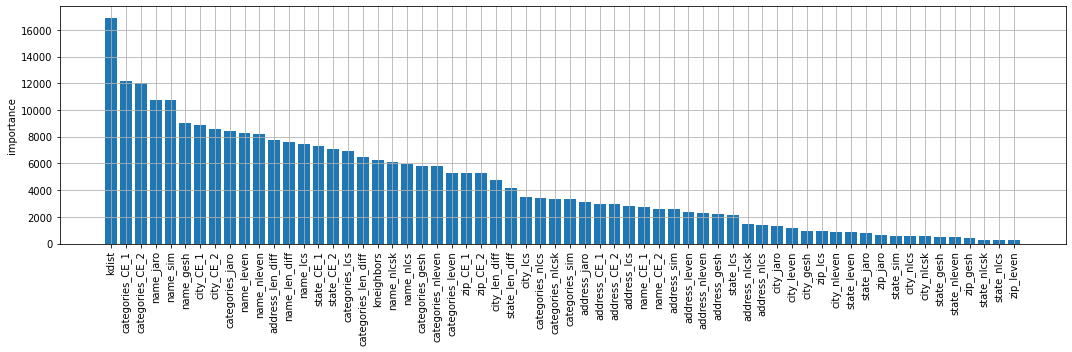

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

#Check CV

In [ ]:
test_data = add_features(test_data, 1)
pred = inference_lgb(models, test_data[features])
test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
def post_process(df):
    id2match = dict(zip(df['id'].values, df['matches'].str.split()))

    for base, match in df[['id', 'matches']].values:
        match = match.split()
        if len(match) == 1:        
            continue

        for m in match:
            if base not in id2match[m]:
                id2match[m].append(base)
    df['matches'] = df['id'].map(id2match).map(' '.join)
    return df 

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-06-02 12:31:32,513] A new study created in memory with name: no-name-4e6ee7b0-62cd-43ef-8fab-055890d330e1
[I 2022-06-02 12:31:57,561] Trial 0 finished with value: 0.7674188772653315 and parameters: {'threshold': 0.0693855840107136}. Best is trial 0 with value: 0.7674188772653315.


CV: 0.767419


[I 2022-06-02 12:32:15,552] Trial 1 finished with value: 0.8282877492070301 and parameters: {'threshold': 0.8007396799288784}. Best is trial 1 with value: 0.8282877492070301.


CV: 0.828288


[I 2022-06-02 12:32:34,671] Trial 2 finished with value: 0.8333059926687496 and parameters: {'threshold': 0.43843514680961726}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.833306


[I 2022-06-02 12:32:55,161] Trial 3 finished with value: 0.6956267437962114 and parameters: {'threshold': 0.021156481839735397}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.695627


[I 2022-06-02 12:33:13,559] Trial 4 finished with value: 0.8189733979255043 and parameters: {'threshold': 0.8769408912020817}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.818973


[I 2022-06-02 12:33:32,731] Trial 5 finished with value: 0.8310008624391537 and parameters: {'threshold': 0.3868401668789033}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.831001


[I 2022-06-02 12:33:51,947] Trial 6 finished with value: 0.7970739183907709 and parameters: {'threshold': 0.1322183125806662}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.797074


[I 2022-06-02 12:34:11,201] Trial 7 finished with value: 0.8315515481094479 and parameters: {'threshold': 0.39737778234882515}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.831552


[I 2022-06-02 12:34:30,045] Trial 8 finished with value: 0.7994584607020832 and parameters: {'threshold': 0.9454729903831205}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.799458


[I 2022-06-02 12:34:48,756] Trial 9 finished with value: 0.8295643342675251 and parameters: {'threshold': 0.3608976492342345}. Best is trial 2 with value: 0.8333059926687496.


CV: 0.829564


[I 2022-06-02 12:35:07,479] Trial 10 finished with value: 0.8346124821006891 and parameters: {'threshold': 0.6683813400147856}. Best is trial 10 with value: 0.8346124821006891.


CV: 0.834612


[I 2022-06-02 12:35:26,226] Trial 11 finished with value: 0.8338496481862925 and parameters: {'threshold': 0.6967884720178013}. Best is trial 10 with value: 0.8346124821006891.


CV: 0.833850


[I 2022-06-02 12:35:45,204] Trial 12 finished with value: 0.8339793356588967 and parameters: {'threshold': 0.6914167637852059}. Best is trial 10 with value: 0.8346124821006891.


CV: 0.833979


[I 2022-06-02 12:36:03,715] Trial 13 finished with value: 0.8355738615258697 and parameters: {'threshold': 0.6123242583994293}. Best is trial 13 with value: 0.8355738615258697.


CV: 0.835574


[I 2022-06-02 12:36:22,572] Trial 14 finished with value: 0.8356193875626416 and parameters: {'threshold': 0.614443765532374}. Best is trial 14 with value: 0.8356193875626416.


CV: 0.835619


[I 2022-06-02 12:36:41,335] Trial 15 finished with value: 0.8357446192138112 and parameters: {'threshold': 0.5633129826547829}. Best is trial 15 with value: 0.8357446192138112.


CV: 0.835745


[I 2022-06-02 12:37:01,070] Trial 16 finished with value: 0.8195173124217442 and parameters: {'threshold': 0.24484780167329456}. Best is trial 15 with value: 0.8357446192138112.


CV: 0.819517


[I 2022-06-02 12:37:19,477] Trial 17 finished with value: 0.8354583647364267 and parameters: {'threshold': 0.5314889407962526}. Best is trial 15 with value: 0.8357446192138112.


CV: 0.835458


[I 2022-06-02 12:37:38,531] Trial 18 finished with value: 0.8357171853418666 and parameters: {'threshold': 0.5555833994430278}. Best is trial 15 with value: 0.8357446192138112.


CV: 0.835717


[I 2022-06-02 12:37:57,573] Trial 19 finished with value: 0.8350328961755727 and parameters: {'threshold': 0.5058994343340374}. Best is trial 15 with value: 0.8357446192138112.


CV: 0.835033


[I 2022-06-02 12:38:17,110] Trial 20 finished with value: 0.8220644707155466 and parameters: {'threshold': 0.26697973871793074}. Best is trial 15 with value: 0.8357446192138112.


CV: 0.822064


[I 2022-06-02 12:38:35,240] Trial 21 finished with value: 0.8357544136036029 and parameters: {'threshold': 0.5678500091504397}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.835754


[I 2022-06-02 12:38:54,048] Trial 22 finished with value: 0.8356534301277952 and parameters: {'threshold': 0.5493060941625825}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.835653


[I 2022-06-02 12:39:12,690] Trial 23 finished with value: 0.8314002194657025 and parameters: {'threshold': 0.7545073310289399}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.831400


[I 2022-06-02 12:39:31,818] Trial 24 finished with value: 0.8357030320803859 and parameters: {'threshold': 0.5921963794271391}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.835703


[I 2022-06-02 12:39:50,706] Trial 25 finished with value: 0.8342010563101372 and parameters: {'threshold': 0.4644522360707826}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.834201


[I 2022-06-02 12:40:10,152] Trial 26 finished with value: 0.8224087446971299 and parameters: {'threshold': 0.2701280486935491}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.822409


[I 2022-06-02 12:40:29,128] Trial 27 finished with value: 0.827928339542952 and parameters: {'threshold': 0.8045152276918048}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.827928


[I 2022-06-02 12:40:48,405] Trial 28 finished with value: 0.8356040824323842 and parameters: {'threshold': 0.5415381811016482}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.835604


[I 2022-06-02 12:41:07,032] Trial 29 finished with value: 0.828061905822941 and parameters: {'threshold': 0.3370842022538254}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.828062


[I 2022-06-02 12:41:26,095] Trial 30 finished with value: 0.8342257720546897 and parameters: {'threshold': 0.46594067743853723}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.834226


[I 2022-06-02 12:41:45,329] Trial 31 finished with value: 0.8356517177926077 and parameters: {'threshold': 0.6057301762636128}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.835652


[I 2022-06-02 12:42:04,442] Trial 32 finished with value: 0.8356861466992885 and parameters: {'threshold': 0.5966256977700676}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.835686


[I 2022-06-02 12:42:23,253] Trial 33 finished with value: 0.831667569702758 and parameters: {'threshold': 0.7491726115152151}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.831668


[I 2022-06-02 12:42:41,268] Trial 34 finished with value: 0.8348693518000643 and parameters: {'threshold': 0.6561793544326355}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.834869


[I 2022-06-02 12:43:00,650] Trial 35 finished with value: 0.8338887007205642 and parameters: {'threshold': 0.45320713307032645}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.833889


[I 2022-06-02 12:43:18,888] Trial 36 finished with value: 0.8272938830174876 and parameters: {'threshold': 0.8115944170477605}. Best is trial 21 with value: 0.8357544136036029.


CV: 0.827294


[I 2022-06-02 12:43:37,951] Trial 37 finished with value: 0.8357752806445232 and parameters: {'threshold': 0.5646104253478069}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835775


[I 2022-06-02 12:43:57,115] Trial 38 finished with value: 0.8350308178060017 and parameters: {'threshold': 0.504886802180488}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835031


[I 2022-06-02 12:44:15,393] Trial 39 finished with value: 0.8323673003889341 and parameters: {'threshold': 0.41580561058980725}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.832367


[I 2022-06-02 12:44:34,709] Trial 40 finished with value: 0.8269067766295055 and parameters: {'threshold': 0.3203878909758646}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.826907


[I 2022-06-02 12:44:53,852] Trial 41 finished with value: 0.8357428469992706 and parameters: {'threshold': 0.5616310769915731}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835743


[I 2022-06-02 12:45:11,919] Trial 42 finished with value: 0.8357302853438996 and parameters: {'threshold': 0.5628953747210965}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835730


[I 2022-06-02 12:45:30,915] Trial 43 finished with value: 0.832562316096314 and parameters: {'threshold': 0.7328605903941163}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.832562


[I 2022-06-02 12:45:49,847] Trial 44 finished with value: 0.8353439145704613 and parameters: {'threshold': 0.6337684727252317}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835344


[I 2022-06-02 12:46:08,951] Trial 45 finished with value: 0.8357182610101308 and parameters: {'threshold': 0.5712352426390274}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835718


[I 2022-06-02 12:46:27,362] Trial 46 finished with value: 0.8348867999302656 and parameters: {'threshold': 0.4926718436042516}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834887


[I 2022-06-02 12:46:46,300] Trial 47 finished with value: 0.8338474042510629 and parameters: {'threshold': 0.6969127577635045}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.833847


[I 2022-06-02 12:47:04,918] Trial 48 finished with value: 0.8207017406016551 and parameters: {'threshold': 0.86660784495266}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.820702


[I 2022-06-02 12:47:24,219] Trial 49 finished with value: 0.8305688629330372 and parameters: {'threshold': 0.37857596137018534}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.830569


[I 2022-06-02 12:47:42,588] Trial 50 finished with value: 0.832492961046967 and parameters: {'threshold': 0.4193293746081811}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.832493


[I 2022-06-02 12:48:01,652] Trial 51 finished with value: 0.835696889885177 and parameters: {'threshold': 0.5807015966379044}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835697


[I 2022-06-02 12:48:20,740] Trial 52 finished with value: 0.8357710809756121 and parameters: {'threshold': 0.5650165880826208}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835771


[I 2022-06-02 12:48:38,698] Trial 53 finished with value: 0.8349178157026329 and parameters: {'threshold': 0.653917165582361}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834918


[I 2022-06-02 12:48:57,567] Trial 54 finished with value: 0.8353238252801053 and parameters: {'threshold': 0.521565949428258}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835324


[I 2022-06-02 12:49:16,364] Trial 55 finished with value: 0.8339163371040653 and parameters: {'threshold': 0.6944912586865439}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.833916


[I 2022-06-02 12:49:35,500] Trial 56 finished with value: 0.8346390707736469 and parameters: {'threshold': 0.4809760515935892}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834639


[I 2022-06-02 12:49:53,833] Trial 57 finished with value: 0.8354865764890103 and parameters: {'threshold': 0.529269805131001}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835487


[I 2022-06-02 12:50:13,047] Trial 58 finished with value: 0.8353370023062984 and parameters: {'threshold': 0.6356465591302066}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835337


[I 2022-06-02 12:50:33,105] Trial 59 finished with value: 0.7924135855188564 and parameters: {'threshold': 0.11815325276685396}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.792414


[I 2022-06-02 12:50:52,165] Trial 60 finished with value: 0.835736979727621 and parameters: {'threshold': 0.5572618537598828}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835737


[I 2022-06-02 12:51:11,193] Trial 61 finished with value: 0.8357582817043354 and parameters: {'threshold': 0.5606458425778875}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835758


[I 2022-06-02 12:51:29,685] Trial 62 finished with value: 0.8355969730872456 and parameters: {'threshold': 0.6133697017316297}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835597


[I 2022-06-02 12:51:50,219] Trial 63 finished with value: 0.8332987230481108 and parameters: {'threshold': 0.4383032420699764}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.833299


[I 2022-06-02 12:52:08,909] Trial 64 finished with value: 0.8356836940815348 and parameters: {'threshold': 0.553462932046407}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835684


[I 2022-06-02 12:52:28,591] Trial 65 finished with value: 0.8350160443337489 and parameters: {'threshold': 0.5032338007607339}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835016


[I 2022-06-02 12:52:49,098] Trial 66 finished with value: 0.8344464908864007 and parameters: {'threshold': 0.6750748851755758}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834446


[I 2022-06-02 12:53:07,995] Trial 67 finished with value: 0.8356918961895814 and parameters: {'threshold': 0.5893945050660829}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835692


[I 2022-06-02 12:53:27,110] Trial 68 finished with value: 0.8330591917203687 and parameters: {'threshold': 0.7194997378839911}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.833059


[I 2022-06-02 12:53:45,957] Trial 69 finished with value: 0.8353246805451572 and parameters: {'threshold': 0.6358929845679865}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835325


[I 2022-06-02 12:54:05,073] Trial 70 finished with value: 0.8354924206521464 and parameters: {'threshold': 0.5335334044022729}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835492


[I 2022-06-02 12:54:23,241] Trial 71 finished with value: 0.8357369606079849 and parameters: {'threshold': 0.5687723461080567}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835737


[I 2022-06-02 12:54:42,365] Trial 72 finished with value: 0.8357163815068238 and parameters: {'threshold': 0.5715395823270809}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835716


[I 2022-06-02 12:55:03,871] Trial 73 finished with value: 0.6638590739935237 and parameters: {'threshold': 0.013722039410550169}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.663859


[I 2022-06-02 12:55:22,907] Trial 74 finished with value: 0.8344725788440291 and parameters: {'threshold': 0.4753919090489213}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834473


[I 2022-06-02 12:55:42,048] Trial 75 finished with value: 0.8356414557072985 and parameters: {'threshold': 0.6066104835654907}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835641


[I 2022-06-02 12:56:00,258] Trial 76 finished with value: 0.8356243776162057 and parameters: {'threshold': 0.5429953973493805}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835624


[I 2022-06-02 12:56:19,780] Trial 77 finished with value: 0.8351554677682884 and parameters: {'threshold': 0.5104827060695498}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835155


[I 2022-06-02 12:56:38,581] Trial 78 finished with value: 0.8353410514231908 and parameters: {'threshold': 0.6350716985627565}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835341


[I 2022-06-02 12:56:56,821] Trial 79 finished with value: 0.8337547324264337 and parameters: {'threshold': 0.450787014592542}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.833755


[I 2022-06-02 12:57:15,532] Trial 80 finished with value: 0.8347360248409416 and parameters: {'threshold': 0.6636445204534961}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834736


[I 2022-06-02 12:57:34,640] Trial 81 finished with value: 0.8357578753148562 and parameters: {'threshold': 0.5672291217282092}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835758


[I 2022-06-02 12:57:53,765] Trial 82 finished with value: 0.8356898546898998 and parameters: {'threshold': 0.5758764441413795}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835690


[I 2022-06-02 12:58:12,334] Trial 83 finished with value: 0.8356847566477662 and parameters: {'threshold': 0.5516086796133595}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835685


[I 2022-06-02 12:58:31,157] Trial 84 finished with value: 0.8355978294552907 and parameters: {'threshold': 0.6156762900699687}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835598


[I 2022-06-02 12:58:50,068] Trial 85 finished with value: 0.8347988136989457 and parameters: {'threshold': 0.48957702140523796}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834799


[I 2022-06-02 12:59:09,053] Trial 86 finished with value: 0.8352473276237772 and parameters: {'threshold': 0.51696316365365}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835247


[I 2022-06-02 12:59:28,073] Trial 87 finished with value: 0.8356784787579089 and parameters: {'threshold': 0.5958642987588543}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835678


[I 2022-06-02 12:59:46,189] Trial 88 finished with value: 0.8298862611462219 and parameters: {'threshold': 0.7766391125310866}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.829886


[I 2022-06-02 13:00:05,420] Trial 89 finished with value: 0.8331573701838648 and parameters: {'threshold': 0.43536831635359396}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.833157


[I 2022-06-02 13:00:23,664] Trial 90 finished with value: 0.835744971772189 and parameters: {'threshold': 0.5590141512459438}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835745


[I 2022-06-02 13:00:42,525] Trial 91 finished with value: 0.8357490335793892 and parameters: {'threshold': 0.5618289629805326}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835749


[I 2022-06-02 13:01:01,593] Trial 92 finished with value: 0.8352650192715332 and parameters: {'threshold': 0.5190509394831836}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835265


[I 2022-06-02 13:01:19,788] Trial 93 finished with value: 0.8355174359322332 and parameters: {'threshold': 0.5354457959038489}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835517


[I 2022-06-02 13:01:37,837] Trial 94 finished with value: 0.7841501974269869 and parameters: {'threshold': 0.9688521029672351}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.784150


[I 2022-06-02 13:01:57,000] Trial 95 finished with value: 0.835705827297417 and parameters: {'threshold': 0.5867833681862034}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835706


[I 2022-06-02 13:02:15,103] Trial 96 finished with value: 0.8355137910535522 and parameters: {'threshold': 0.6222350512677133}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835514


[I 2022-06-02 13:02:33,986] Trial 97 finished with value: 0.8357396394509841 and parameters: {'threshold': 0.5573671626913671}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.835740


[I 2022-06-02 13:02:53,110] Trial 98 finished with value: 0.8342490839260107 and parameters: {'threshold': 0.46664589832889936}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834249


[I 2022-06-02 13:03:11,370] Trial 99 finished with value: 0.8349005000805261 and parameters: {'threshold': 0.4930440102801183}. Best is trial 37 with value: 0.8357752806445232.


CV: 0.834901


In [30]:
threshold = study.best_params['threshold']
threshold

0.5646104253478069

In [31]:
study.best_value

0.8357752806445232

In [32]:
score = study.best_value
print(f"CV: {score:.6f}")

CV: 0.835775


# testデータの追加

In [33]:
class UnionFind():
    def __init__(self, n):
        self.n = n
        self.parents = [-1] * n

    def find(self, x):
        if self.parents[x] < 0:
            return x
        else:
            self.parents[x] = self.find(self.parents[x])
            return self.parents[x]

    def union(self, x, y):
        x = self.find(x)
        y = self.find(y)

        if x == y:
            return

        if self.parents[x] > self.parents[y]:
            x, y = y, x

        self.parents[x] += self.parents[y]
        self.parents[y] = x

    def size(self, x):
        return -self.parents[self.find(x)]

    def same(self, x, y):
        return self.find(x) == self.find(y)

    def members(self, x):
        root = self.find(x)
        return [i for i in range(self.n) if self.find(i) == root]

    def roots(self):
        return [i for i, x in enumerate(self.parents) if x < 0]

    def group_count(self):
        return len(self.roots())

    def all_group_members(self):
        return {r: self.members(r) for r in self.roots()}

    def __str__(self):
        return '\n'.join('{}: {}'.format(r, self.members(r)) for r in self.roots())

In [34]:
id2idx = {x:i for i, x in enumerate(data[data['set'] == 1].index)}
idx2id = {i:x for i, x in enumerate(data[data['set'] == 1].index)}

In [35]:
S = set()
for id, match_id in zip(test_data[test_data['pred'] > threshold]['id'], test_data[test_data['pred'] > threshold]['match_id']):
    S.add((id, match_id))
    S.add((match_id, id))

In [ ]:
UFT = UnionFind(len(data[data['set'] == 1]))
for id, match_id in zip(test_data[test_data['pred'] > threshold]['id'], test_data[test_data['pred'] > threshold]['match_id']):
    UFT.union(id2idx[id], id2idx[match_id])

In [ ]:
parents = UFT.parents
for i in range(len(parents)):
    if parents[i] < 0:
        parents[i] = i

In [ ]:
parent2ids = defaultdict(list)
for i in range(len(parents)):
    parent2ids[parents[i]].append(i)

In [ ]:
ids = []
match_ids = []
labels = []
for k, idxs in parent2ids.items():
    if len(idxs) <= 2:
        continue
    for i in range(len(idxs) - 1):
        for j in range(i + 1, len(idxs)):
            id = idx2id[idxs[i]]
            match_id = idx2id[idxs[j]]
            if not (id, match_id) in S:
                if data.loc[id, 'point_of_interest'] == data.loc[match_id, 'point_of_interest']:
                    labels.append(1)
                else:
                    labels.append(0)
                ids.append(id)
                match_ids.append(match_id)
                S.add((id, match_id))
                S.add((match_id, id))

In [ ]:
latlon_values = data.loc[ids, ['latitude', 'longitude']].values
match_latlon_values = data.loc[match_ids, ['latitude', 'longitude']].values
kdist = []
for latlon, match_latlon in tqdm(zip(latlon_values, match_latlon_values)):
    kdist.append(haversine_distances([latlon, match_latlon])[0, 1])

0it [00:00, ?it/s]

In [ ]:
add_test_data = pd.DataFrame()
add_test_data['id'] = ids
add_test_data['match_id'] = match_ids
add_test_data['kdist'] = kdist
add_test_data['kneighbors'] = CFG.num_neighbors
add_test_data['label'] = labels
add_test_data.head()

,id,match_id,kdist,kneighbors,label
0,E_0000764d65557e,E_30424388e6852c,0.000845,20,1
1,E_000156e4ae899c,E_e656f42d5d2d8d,0.013149,20,0
2,E_0002621cad235f,E_b9fa366e8610cd,0.002244,20,0
3,E_3080e519354e6a,E_88ac538141dea4,0.005251,20,0
4,E_3080e519354e6a,E_b9fa366e8610cd,0.002277,20,0


In [ ]:
add_test_data = add_features(add_test_data, 1)
pred = inference_lgb(models, add_test_data[features])
add_test_data['pred'] = pred[:, 1]

  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    test_pred_df = test_data[test_data['pred'] > x][['id', 'match_id']]
    add_test_pred_df = add_test_data[add_test_data['pred'] > x][['id', 'match_id']]
    out_df = pd.DataFrame()
    out_df['id'] = test_data['id'].unique().tolist()
    out_df['match_id'] = out_df['id']
    out_df = pd.concat([out_df, test_pred_df])
    out_df = pd.concat([out_df, add_test_pred_df])
    out_df = out_df.groupby('id')['match_id'].\
                        apply(list).reset_index()
    out_df['matches'] = out_df['match_id'].apply(lambda x: ' '.join(set(x)))
    out_df = post_process(out_df)

    score = get_score(out_df)
    print(f"CV: {score:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [ ]:
threshold = study.best_params['threshold']
threshold

In [ ]:
study.best_value

In [ ]:
score = study.best_value
print(f"CV: {score:.6f}")

# 間違っているものの中身を見る

In [ ]:
data = data.reset_index()

labelが1なのに0と予測しているもの

In [ ]:
false_negative = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] <= threshold), :]
false_negative.describe()

In [ ]:
false_negative.sample(min(false_negative.shape[0], 30))

In [ ]:
for id, match_id in false_negative.sample(min(false_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

labelが0なのに1と予測しているもの

In [ ]:
false_positive = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] > threshold), :]
false_positive.describe()

In [ ]:
false_positive.sample(min(false_positive.shape[0], 30))

In [ ]:
for id, match_id in false_positive.sample(min(false_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

labelが1で1と予測しているもの

In [ ]:
true_positive = test_data.loc[(test_data["label"] == 1) & (test_data["pred"] > threshold), :]
true_positive.describe()

In [ ]:
true_positive.sample(min(true_positive.shape[0], 30))

In [ ]:
for id, match_id in true_positive.sample(min(true_positive.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])

labelが0で0と予測しているもの

In [ ]:
true_negative = test_data.loc[(test_data["label"] == 0) & (test_data["pred"] <= threshold), :]
true_negative.describe()

In [ ]:
true_negative.sample(min(true_negative.shape[0], 30))

In [ ]:
for id, match_id in true_negative.sample(min(true_negative.shape[0], 30))[['id', 'match_id']].values:
    display(data[data['id'].isin([id, match_id])])